In [6]:
import time
import numpy as np
import random
import keras_tuner as kt
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import GlobalMaxPooling2D, Activation, Dense, Conv1D, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras import optimizers
import itertools
from sklearn.utils import shuffle
from scipy import signal
%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

In [7]:
def showHistory(history):
    plt.rcParams['figure.figsize'] = [5, 5]
    for key in history.history.keys():

        if 'val_' not in key and 'lr' != key:
            try:
                plt.clf()
                plt.plot(history.history[key])
                plt.plot(history.history['val_'+key])
                plt.ylabel(key)
                plt.xlabel('epoch')
                plt.legend(['train', 'validation'], loc='upper left')
                plt.show()
            except:
                ...


classes = ['Rest','EyeBrow','Chew']

def smoothLabels(label, factor = 0.):
    label *= (1 - factor)
    label += (factor / len(label))
    return label

def oneHot(label, classes = classes):
    label = to_categorical(label,num_classes=len(classes))
    return smoothLabels(label)

def applyOneHot(data):
    new = []
    for y in data:
        new.append(oneHot(y))
    return np.array(new)

def DCFilter(data):
    new_data = []
    for d in data:
        new_data.append(d-np.mean(d))
    return np.array(new_data)

def notchFilter(data, f0 = 60.0, Q = 30.0, fs = 500):
    b, a = signal.iirnotch(f0, Q, fs)
    data = signal.filtfilt(b, a, data, axis=1)
    return np.array(data)

def preProcess(data):
    data = signal.resample(data,   signal_length,axis =-1)
  
    new_data = []
    for d in data:
        d = DCFilter(d)
        d = notchFilter(d)
        scaler = StandardScaler()
        scaler.fit(d)
        d = scaler.transform(d)
        new_data.append(normalize(d, norm='l2'))
    return np.array(new_data)

def showMe(data):
    
    plt.rcParams["figure.figsize"] = [17, 2]
    fig, (c1, c2, c3, c4, c5, c6) = plt.subplots(1, 6)
    c1.plot(data[0])
    c2.plot(data[1])
    c3.plot(data[2])
    c4.plot(data[3])
    c5.plot(data[4])
    c6.plot(data[5])
    plt.show()

In [14]:
signal_length = 100

resource_path = 'resources/'
train_sessions = ['session_0','session_1', 'session_2', 'session_3']
test_sessions  = ['session_0','session_1', 'session_2', 'session_3', 'session_4']

rests = []
eyebrows = []
chews = []
for session in train_sessions:
    rests.append(np.load(os.path.join(resource_path,session,'Rest.npy')))
    eyebrows.append(np.load(os.path.join(resource_path,session,'Eyebrow.npy')))
    chews.append(np.load(os.path.join(resource_path,session,'Chew.npy')))
rests = np.concatenate((rests),axis=0)
eyebrows = np.concatenate((eyebrows),axis=0)
chews = np.concatenate((chews),axis=0)


rests = preProcess(rests)
eyebrows = preProcess(eyebrows)
chews = preProcess(chews)
print(rests.shape)


(80, 6, 100)


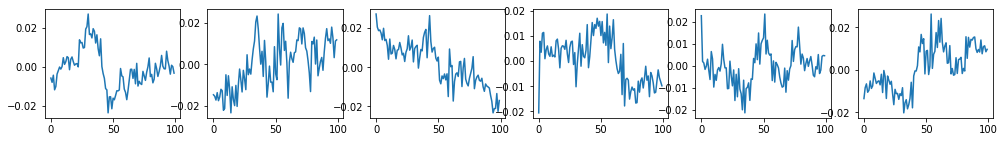

In [15]:
rests_avg = rests.mean(axis=0)
showMe(rests_avg)

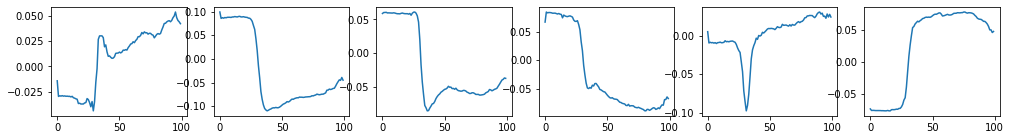

In [16]:
eyebrows_avg = eyebrows.mean(axis=0)
showMe(eyebrows_avg)

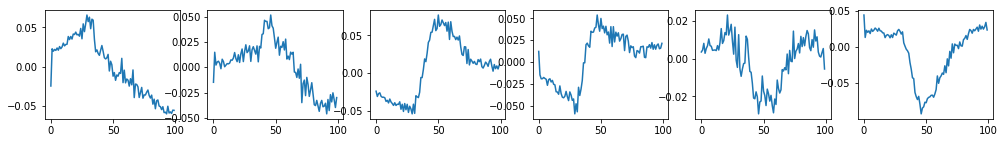

In [17]:
chews_avg = chews.mean(axis=0)
showMe(chews_avg)

In [ ]:
for i in range(5):
    showMe(eyebrows[i])

In [ ]:
for i in range(5):
    showMe(rests[i])

In [18]:
X = np.concatenate((rests,eyebrows,chews),axis = 0)
y = np.concatenate(( np.zeros(rests.shape[0]),np.ones(eyebrows.shape[0]),np.ones(eyebrows.shape[0])*2))


#SHUFFLE DATA
c = list(zip(X, y))
random.shuffle(c)
X,y = zip(*c)
X = np.array(X)
y = np.array(y)

y = applyOneHot(y)


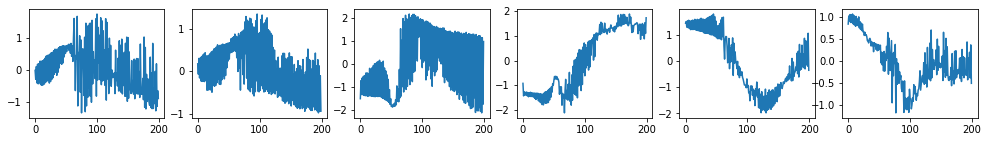

In [32]:
showMe(X[1])

In [19]:
#AUGMENT
noise = np.random.normal(0,0.1,X.size)
noise = np.reshape(noise,X.shape)

augmented = X + noise
X_aug = np.concatenate((X,augmented))
y_aug = np.concatenate((y,y))

print(X_aug.shape)
print(y_aug.shape)

(480, 6, 100)
(480, 3)


In [38]:
def get_dense_model():
    inspected_chanels= X.shape[1]
    signal_length=     X.shape[2]
    input_layer = keras.Input(shape = (inspected_chanels,signal_length), name='input')
    x = layers.Flatten()(input_layer)

    l2 = 0.001
    x     = layers.Dense(200,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)


    x     = layers.Dense(100,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)



    x     = layers.Dense(50,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.Dropout(.2)(x)


    x     = layers.Dense(30,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)



    x     = layers.Dense(10,kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
    x     = layers.Dropout(.3)(x)


    output = layers.Dense(3, activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)

    model.summary()
    return model

In [75]:
def get_hyper_model(hp):
    model = keras.Sequential()
    inspected_chanels= X.shape[1]
    signal_length=     X.shape[2]
    input_layer = keras.Input(shape = (inspected_chanels,signal_length), name='input')
    x = layers.Flatten()(input_layer)
    l2 = 0.001
    for i in range(hp.Choice('n_layers',[1,2,4,6])):
        x     = layers.Dense(hp.Int('dense',min_value=10,max_value=1000,sampling="log"),kernel_regularizer=regularizers.l2(l2))(x)
        x     = layers.BatchNormalization()(x)
        x     = layers.Dropout(hp.Choice('dropout',[0., 0.1,0.2]))(x)


    output = layers.Dense(3, activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)


    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log"),
        decay_steps=batch_size*10,
        decay_rate=hp.Choice('decay',[0.1,0.9]))


    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    model.summary()
    return model

In [40]:

model = get_dense_model()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-3,
    decay_steps=1000,
    decay_rate=0.1
    )

opt = keras.optimizers.SGD(learning_rate=lr_schedule) #, momentum=0.9, nesterov=True)
model.compile(optimizer=opt,
          loss='categorical_crossentropy',
          metrics=['accuracy']
         )


Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 6, 100)]          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 600)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 200)               120200    
_________________________________________________________________
batch_normalization_25 (Batc (None, 200)               800       
_________________________________________________________________
dense_31 (Dense)             (None, 100)               20100     
_________________________________________________________________
batch_normalization_26 (Batc (None, 100)               400       
_________________________________________________________________
dense_32 (Dense)             (None, 50)              

Batch size: 20
Epoch 1/50
 3/22 [===>..........................] - ETA: 0s - loss: 2.4917 - accuracy: 0.2500

C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


22/22 [==============================] - 1s 34ms/step - loss: 1.9115 - accuracy: 0.4537 - val_loss: 1.4162 - val_accuracy: 0.6458
Epoch 2/50
22/22 [==============================] - 1s 33ms/step - loss: 1.4568 - accuracy: 0.5995 - val_loss: 1.3807 - val_accuracy: 0.6667
Epoch 3/50
22/22 [==============================] - 1s 33ms/step - loss: 1.2909 - accuracy: 0.6713 - val_loss: 1.3553 - val_accuracy: 0.6875
Epoch 4/50
22/22 [==============================] - 1s 34ms/step - loss: 1.1789 - accuracy: 0.7338 - val_loss: 1.3340 - val_accuracy: 0.7083
Epoch 5/50
22/22 [==============================] - 1s 39ms/step - loss: 1.1996 - accuracy: 0.6991 - val_loss: 1.3139 - val_accuracy: 0.7292
Epoch 6/50
22/22 [==============================] - 1s 33ms/step - loss: 1.1226 - accuracy: 0.7523 - val_loss: 1.2967 - val_accuracy: 0.7292
Epoch 7/50
22/22 [==============================] - 1s 30ms/step - loss: 1.0611 - accuracy: 0.7986 - val_loss: 1.2760 - val_accuracy: 0.6875
Epoch 8/50
22/22 [======

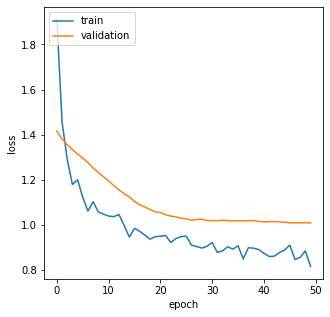

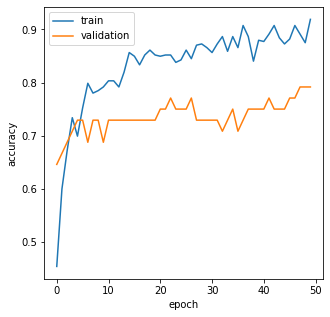

Batch size: 20
Epoch 1/50
22/22 [==============================] - 1s 35ms/step - loss: 0.8691 - accuracy: 0.8819 - val_loss: 0.8119 - val_accuracy: 0.9375
Epoch 2/50
22/22 [==============================] - 1s 36ms/step - loss: 0.8468 - accuracy: 0.9028 - val_loss: 0.8128 - val_accuracy: 0.9375
Epoch 3/50
22/22 [==============================] - 1s 36ms/step - loss: 0.8910 - accuracy: 0.8727 - val_loss: 0.8138 - val_accuracy: 0.9375
Epoch 4/50
22/22 [==============================] - 1s 37ms/step - loss: 0.8869 - accuracy: 0.8796 - val_loss: 0.8145 - val_accuracy: 0.9375
Epoch 5/50
22/22 [==============================] - 1s 36ms/step - loss: 0.8736 - accuracy: 0.8889 - val_loss: 0.8151 - val_accuracy: 0.9375
Epoch 6/50
22/22 [==============================] - 1s 36ms/step - loss: 0.9014 - accuracy: 0.8565 - val_loss: 0.8143 - val_accuracy: 0.9375
Epoch 7/50
22/22 [==============================] - 1s 35ms/step - loss: 0.8501 - accuracy: 0.8912 - val_loss: 0.8135 - val_accuracy: 0.937

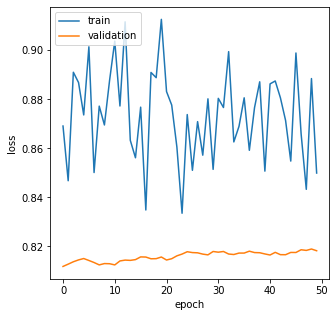

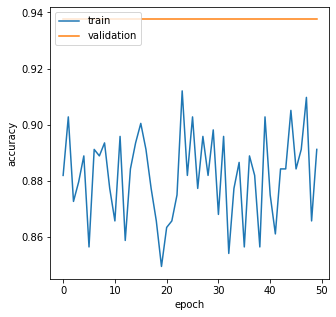

0.7916666865348816
0.9375


In [103]:
skf = StratifiedKFold(n_splits=10)
tf.config.run_functions_eagerly(True)
accs = []
models = []
for train, test in skf.split(X_aug, y_aug.argmax(axis=1)):
  
    X_train = X_aug[train]
    X_test  = X_aug[test]
    y_train = y_aug[train]
    y_test  = y_aug[test]


    X_train = np.expand_dims(X_train, axis = -1) 
    X_test  = np.expand_dims(X_test,  axis = -1)

    batch_size = 20 #len(X_train)
    print("Batch size: {}".format(batch_size))

    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_test, y_test),
                        batch_size=batch_size,
                        epochs=50,
                        shuffle=True)

    showHistory(history)          
    acc = max(history.history['val_accuracy'])
    accs.append(acc)                       
    models.append(model)
    if acc > 0.9:
        break


model = models[accs.index(max(accs))]
for acc in accs:
    print(acc)

In [ ]:
skf = StratifiedKFold(n_splits=10)
tf.config.run_functions_eagerly(True)

for train, test in skf.split(X, y.argmax(1)):
  
    X_train = X[train]
    X_test  = X[test]
    y_train = y[train]
    y_test  = y[test]

    batch_size = 30 #len(X_train)
    print("Batch size: {}".format(batch_size))


    tuner = kt.tuners.RandomSearch(
        get_hyper_model,
        objective='val_accuracy',
        max_trials=100)

    tuner.search(   X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    epochs=100,
                    shuffle=True)

    best_model = tuner.get_best_models()[0]
                             
    break
   

In [24]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
n_layers: 1
dense: 22
dropout: 0.2
lr: 0.0009359788534144154
decay: 0.1
Score: 0.9444444179534912
Trial summary
Hyperparameters:
n_layers: 6
dense: 760
dropout: 0.1
lr: 0.00038316979115832244
decay: 0.9
Score: 0.8888888955116272
Trial summary
Hyperparameters:
n_layers: 6
dense: 68
dropout: 0.1
lr: 0.0026619800162710925
decay: 0.9
Score: 0.8888888955116272
Trial summary
Hyperparameters:
n_layers: 6
dense: 292
dropout: 0.1
lr: 0.007578897916446779
decay: 0.9
Score: 0.8888888955116272
Trial summary
Hyperparameters:
n_layers: 6
dense: 43
dropout: 0.1
lr: 0.0001671064584501386
decay: 0.9
Score: 0.8888888955116272
Trial summary
Hyperparameters:
n_layers: 2
dense: 36
dropout: 0.1
lr: 0.0003309888334695231
decay: 0.9
Score: 0.8888888955116272
Trial summary
Hyperparameters:
n_layers: 4
dense: 816
dropout: 0.0
lr: 0.006006969118465886
decay: 0.1
Scor

In [101]:
def evaluate(session):
    correct = 0
    incorrect = 0

    rests    = np.load(resource_path+session+'/Rest.npy')
    eyebrows = np.load(resource_path+session+'/Eyebrow.npy')
    chews    = np.load(resource_path+session+'/Chew.npy')

    rests = preProcess(rests)
    eyebrows = preProcess(eyebrows)
    chews = preProcess(chews)

    rests = np.expand_dims(rests, axis = -1) 
    eyebrows = np.expand_dims(eyebrows, axis = -1)
    chews = np.expand_dims(chews, axis = -1)


    pred = model.predict(rests)
    for p in pred:
        if p.argmax()==0:
            correct+=1
        else:
            incorrect+=1

    pred = model.predict(eyebrows)
    for p in pred:
        if p.argmax()==1:
            correct+=1
        else:
            incorrect+=1

    pred = model.predict(chews)
    for p in pred:
        if p.argmax()==2:
            correct+=1
        else:
            incorrect+=1
   

    print('Total:{}, correct:{}, acc:{}%'.format(correct+incorrect,correct,round(correct/(correct+incorrect),2)*100))

    

In [104]:
for session in test_sessions:
    print("Evaluating session: {}".format(session))
    evaluate(session)

Evaluating session: session_0
Total:60, correct:51, acc:85.0%
Evaluating session: session_1


C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Total:60, correct:59, acc:98.0%
Evaluating session: session_2
Total:60, correct:58, acc:97.0%
Evaluating session: session_3


C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Total:60, correct:52, acc:87.0%
Evaluating session: session_4
Total:60, correct:40, acc:67.0%


C:\Users\Nemes\anaconda3\envs\tf\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
